In [3]:

import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
from sklearn.cluster import k_means
import pydicom
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.cluster.fcm import fcm

Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 192
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.2.840.113619.2.134.1762810675.1868.1068286415.435
(0002,0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 0.0.0.0
(0002,0013) Implementation Version Name         SH: 'NOTSPECIFIED'
(0002,0016) Source Application Entity Title     AE: 'NOTSPECIFIED'
-------------------------------------------------
(0008,0005) Specific Character Set              CS: 'ISO_IR 100'
(0008,0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'OTHER']
(0008,0012) Instance Creation Date              DA: '20031108'
(0008,0013) Instance Creation Time              TM: '122956'
(0008,0014) Instance Creator UID                UI: 0.0.0.0
(

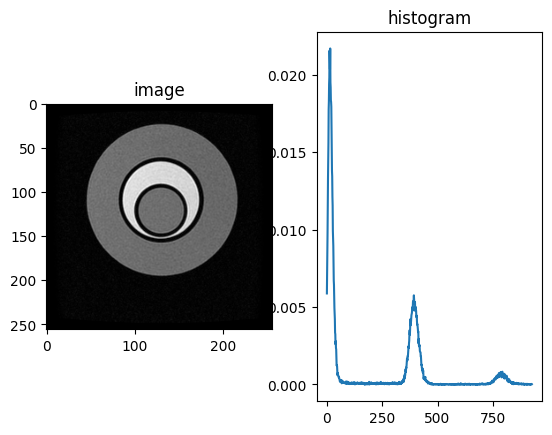

(256, 256)


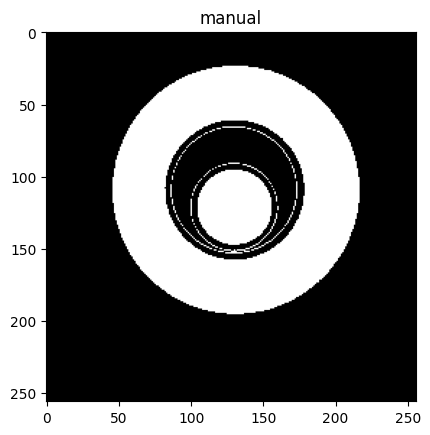

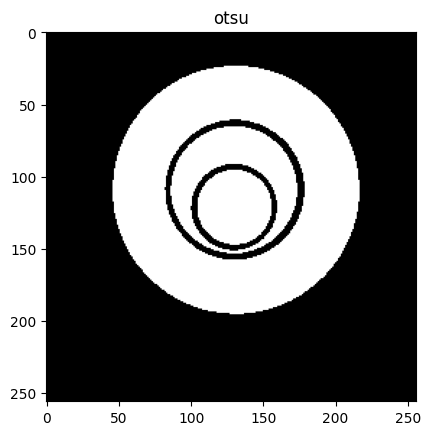

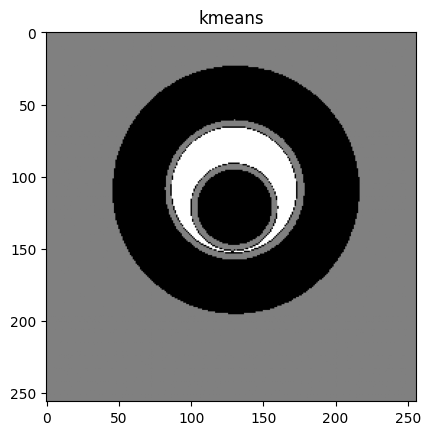

soglie =  [204.35383932 589.24759294]


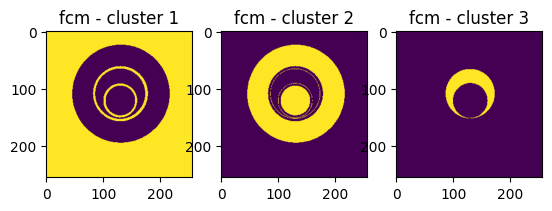

In [4]:
# load image
ds = pydicom.dcmread('../data/phantom.dcm')
image = ds.pixel_array
print(ds)

# get histogram
p = np.max(image, None)
print(p)
counts, bins = np.histogram(image, bins = p)

# display phantom image and image histogram
fig, ax = plt.subplots(1,2)
ax[0].imshow(image, cmap = "gray")
ax[1].plot(counts[1:]/np.sum(counts, None))
ax[0].set_title('image')
ax[1].set_title('histogram')
plt.show()

# manual segmentation of water signal (dall'isto sopra 200 e sotto 600)
mask = np.zeros((ds.Rows, ds.Columns), None)
print(mask.shape)

id = np.logical_and(image > 200, image<600)
mask[id] = 255
plt.figure()
plt.imshow(mask, cmap = "gray")
plt.title('manual')
plt.show()

# otsu algorithm
otsu_thresh = threshold_otsu(image)
image_otsu = image > otsu_thresh
plt.figure()
plt.imshow(image_otsu, cmap = 'gray')
plt.title('otsu')
plt.show()

#### kmeans ####
x = image.reshape((-1,1))
centroid, label, inertia = k_means(x, n_clusters = 3)
image_classes = label.reshape(image.shape)
plt.figure()
plt.imshow(image_classes, cmap = 'gray')
plt.title('kmeans')
plt.show()
c = np.sort(centroid, axis = 0)
T = np.array([np.mean(c[0:2]), np.mean(c[1:3])])
print("soglie = ", T)

#### fuzzy cmeans ####
# initialize centers
initial_centers = kmeans_plusplus_initializer(x, 3, kmeans_plusplus_initializer.FARTHEST_CENTER_CANDIDATE).initialize()

# create instance of Fuzzy C-Means algotirhm
fcm_instance = fcm(x, initial_centers)

# run cluster analysis and obtain results
fcm_instance.process()
clusters = fcm_instance.get_clusters()
centers = fcm_instance.get_centers()

mask1 = np.zeros_like(x)
mask1[clusters[0]]=1
mask1 = mask1.reshape(image.shape)
mask2 = np.zeros_like(x)
mask2[clusters[1]]=1
mask2 = mask2.reshape(image.shape)
mask3 = np.zeros_like(x)
mask3[clusters[2]]=1
mask3 = mask3.reshape(image.shape)
fig, ax = plt.subplots(1,3)
ax[0].imshow(mask1)
ax[1].imshow(mask2)
ax[2].imshow(mask3)
ax[0].set_title('fcm - cluster 1')
ax[1].set_title('fcm - cluster 2')
ax[2].set_title('fcm - cluster 3')
plt.show()


